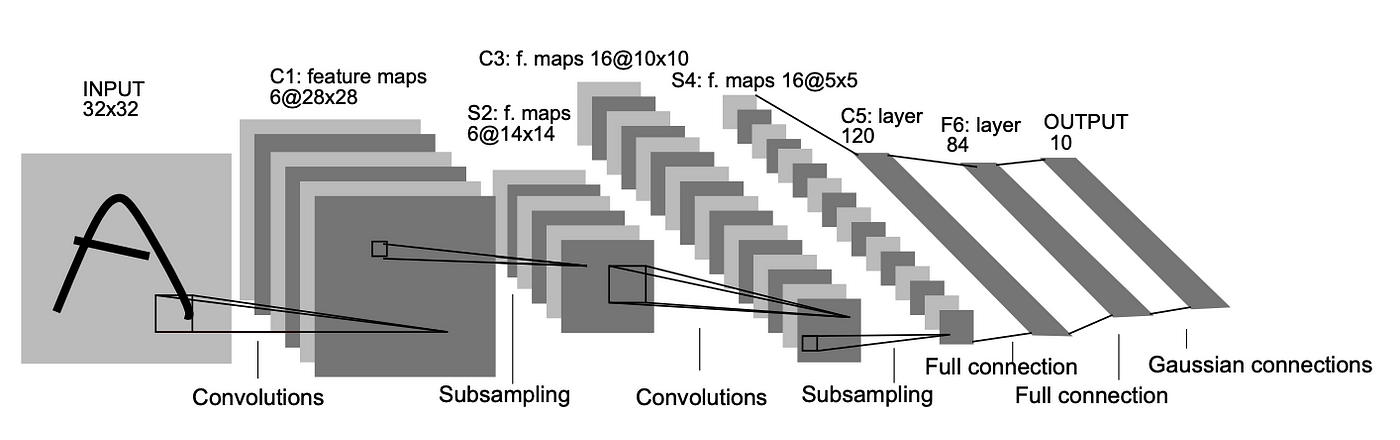

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
#Hyper parameter
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

**Load the MNIST Data**

In [4]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

In [5]:
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transform,
                                           download = True)



100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:10<00:00, 966106.64it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 28972899.74it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 928409.51it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4976627.16it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transform,
                                          download=True)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [8]:
for X, y in train_loader:
  print(X.shape)
  break

torch.Size([64, 1, 32, 32])


**LeNet-5 Model**

In [10]:

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv_layers= nn.Sequential(
            nn.Conv2d(1,6,5), #[1, 6, 28, 28] #Gray image
            nn.ReLU(),
            nn.AvgPool2d(2,2), #[1, 6, 14, 14]
            nn.Conv2d(6,16,5), #[1, 16, 10, 10]
            nn.ReLU(),
            nn.AvgPool2d(2,2), #[1, 16, 5, 5]
        )
        self.fc_layers= nn.Sequential(
            nn.Linear(16*5*5, 120), #120 neurons
            nn.LeakyReLU(),
            nn.Linear(120,84), #84 neurons
            nn.ReLU(),
            nn.Linear(84,num_classes), #10 neurons

        )

    def forward(self, x):
        x= self.conv_layers(x)
        x= x.reshape(x.shape[0], -1)
        x= self.fc_layers(x)
        return x

In [11]:
model = LeNet()
model.to(device)

LeNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

**Loss and optimizer**

In [13]:
loss_fn = nn.CrossEntropyLoss() #mulitclass 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Train the model**

In [14]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [400/938], Loss: 0.2497
Epoch [1/10], Step [800/938], Loss: 0.1132
Epoch [2/10], Step [400/938], Loss: 0.0483
Epoch [2/10], Step [800/938], Loss: 0.0145
Epoch [3/10], Step [400/938], Loss: 0.0126
Epoch [3/10], Step [800/938], Loss: 0.0293
Epoch [4/10], Step [400/938], Loss: 0.0517
Epoch [4/10], Step [800/938], Loss: 0.0423
Epoch [5/10], Step [400/938], Loss: 0.0051
Epoch [5/10], Step [800/938], Loss: 0.1542
Epoch [6/10], Step [400/938], Loss: 0.0288
Epoch [6/10], Step [800/938], Loss: 0.1617
Epoch [7/10], Step [400/938], Loss: 0.1257
Epoch [7/10], Step [800/938], Loss: 0.0188
Epoch [8/10], Step [400/938], Loss: 0.0093
Epoch [8/10], Step [800/938], Loss: 0.0053
Epoch [9/10], Step [400/938], Loss: 0.0465
Epoch [9/10], Step [800/938], Loss: 0.0116
Epoch [10/10], Step [400/938], Loss: 0.0069
Epoch [10/10], Step [800/938], Loss: 0.0107


**Accuracy**

In [16]:
true_labels = [] #for confusion matrix
predicted_labels = [] #for confusion matrix

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
                                
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy= 100 * correct / total
    print('Accuracy of the network on the 10000 test images: {} %'.format(accuracy))
    top1_error = 100 - accuracy
    print('Top-1 Error: {} %'.format(top1_error))



Accuracy of the network on the 10000 test images: 98.99 %
Top-1 Error: 1.0100000000000051 %


**Confusion matrix**

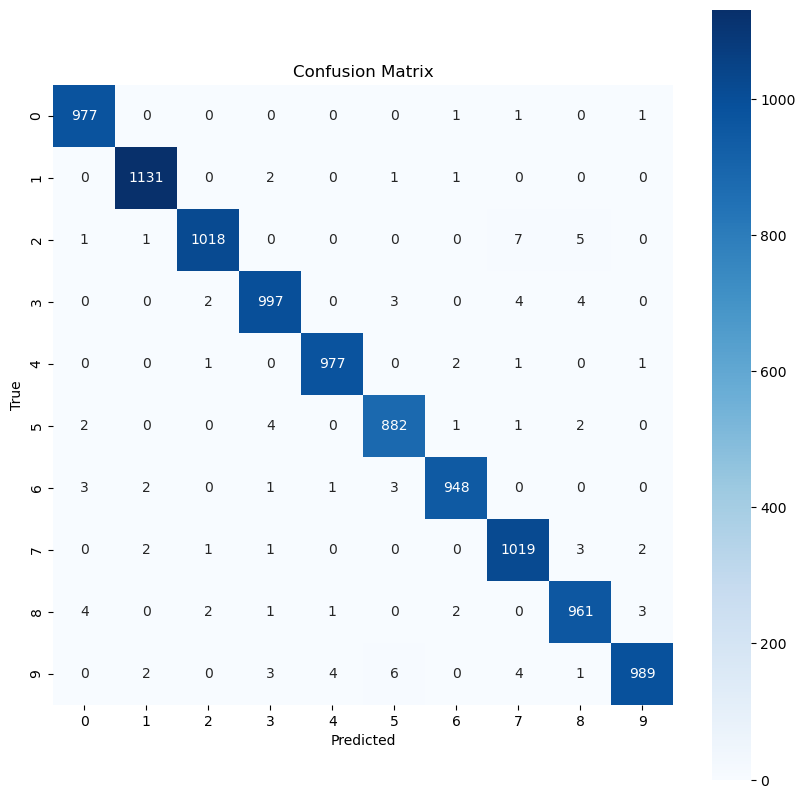

In [17]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(num_classes, num_classes))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Classification report**

In [18]:
report = classification_report(true_labels, predicted_labels)
print('\n'+ report)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [19]:
# Calculate precision, recall, f1 score
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)


for class_label in range(10):
    print(f'Class {class_label}:')
    print(f'Precision: {precision[class_label]:.2f}')
    print(f'Recall: {recall[class_label]:.2f}')
    print(f'F1-score: {f1[class_label]:.2f}')
    print()


Class 0:
Precision: 0.99
Recall: 1.00
F1-score: 0.99

Class 1:
Precision: 0.99
Recall: 1.00
F1-score: 1.00

Class 2:
Precision: 0.99
Recall: 0.99
F1-score: 0.99

Class 3:
Precision: 0.99
Recall: 0.99
F1-score: 0.99

Class 4:
Precision: 0.99
Recall: 0.99
F1-score: 0.99

Class 5:
Precision: 0.99
Recall: 0.99
F1-score: 0.99

Class 6:
Precision: 0.99
Recall: 0.99
F1-score: 0.99

Class 7:
Precision: 0.98
Recall: 0.99
F1-score: 0.99

Class 8:
Precision: 0.98
Recall: 0.99
F1-score: 0.99

Class 9:
Precision: 0.99
Recall: 0.98
F1-score: 0.99



**Top1 error**

In [20]:
accuracy = accuracy_score(true_labels, predicted_labels)* 100
print(f'Accuracy: {accuracy:.2f}%')
top1_error = 100 - accuracy
print('Top-1 Error: {} %'.format(top1_error))

Accuracy: 98.99%
Top-1 Error: 1.0100000000000051 %
